<a href="https://colab.research.google.com/github/abbyh1/AI-Energy-Prediction-Engine/blob/main/KPMG_1E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. Importing necessary libraries and modules**

In [ ]:
## Basic Data Science Modules
import pandas as pd ## dataframes
import numpy as np ## numerical computation
import seaborn as sns ## sophisticated charts, graphs
import matplotlib.pyplot as plt ## basic charts, graphs

In [ ]:
# Import all necessary libraries
import requests
import json
import time
import pickle
from scipy import stats

In [ ]:
## Machine learning modules
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
## for automatic data profiling output
!pip install ydata_profiling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.3/399.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2


In [ ]:
from tqdm import tqdm
from ydata_profiling import ProfileReport

In [ ]:
# Set global options for display
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

# **1. DATA ACQUISITION & DATAFRAME CREATION**


In [ ]:
### Load Data: Retrieve File List
# Define base URLs for the Hugging Face Space
SPACE_ID = "ml-energy/leaderboard"
BASE_URL = f"https://huggingface.co/spaces/{SPACE_ID}/resolve/main/"
API_URL = f"https://huggingface.co/api/spaces/{SPACE_ID}"

In [ ]:
# Get the complete file list from the space API
try:
    response = requests.get(API_URL)
    response.raise_for_status()
    space_info = response.json()
except requests.exceptions.RequestException as e:
    print(f"Error accessing Space API: {e}")
    # In a real tutorial, you might load a cached file here if API fails
    exit()

In [ ]:
# Filter for all JSON files located in the 'data/' directory
json_files = [
    file_info.get('rfilename')
    for file_info in space_info.get('siblings', [])
    if file_info.get('rfilename', '').startswith('data/') and file_info.get('rfilename', '').endswith('.json')
]
print(f"Found {len(json_files)} relevant JSON files.")

Found 481 relevant JSON files.


In [ ]:
### Create DataFrame: Download and Aggregate JSON Files
all_data = []
print("Starting download and aggregation...")

# Loop through all file paths with a progress bar
for file_path in tqdm(json_files, desc="Processing JSON Files"):
    file_url = BASE_URL + file_path

    try:
        response = requests.get(file_url, timeout=5)
        response.raise_for_status()
        data = response.json()

        # Ensure data is a list of dictionaries before appending
        if isinstance(data, list):
            for item in data:
                item['file_path'] = file_path
                all_data.append(item)
        elif isinstance(data, dict):
            data['file_path'] = file_path
            all_data.append(data)

        time.sleep(0.01) # Small delay to be polite to the server

    except Exception as e:
        # Catch various download/parse errors without stopping the whole process
        # print(f"\nWarning: Failed to process {file_path}: {e}") # Keep silent for clean output
        continue

all_data_df = pd.DataFrame(all_data)
print(f"Successfully created initial DataFrame with shape: {df.shape}")

Starting download and aggregation...


Processing JSON Files: 100%|██████████| 481/481 [00:57<00:00,  8.40it/s]

Successfully created initial DataFrame with shape: (481, 83)


# **2. DATA PROFILING**

To assess data quality, structure, and completeness by collecting informative summaries and statistics.

In [ ]:
## make a copy of the dataset
df = all_data_df.copy()

In [ ]:
## view first 5 rows
df.head()

,Model,GPU,Energy/video (J),Batch latency (s),Batch size,Denoising steps,Frames,file_path,ali-vilab/i2vgen-xl,stabilityai/stable-video-diffusion-img2vid,stabilityai/stable-video-diffusion-img2vid-xt,Energy/image (J),kandinsky-community/kandinsky-2-2-decoder,kandinsky-community/kandinsky-3,prompthero/openjourney-v4,segmind/SSD-1B,stabilityai/sdxl-turbo,stabilityai/stable-diffusion-2-1,stabilityai/stable-diffusion-3-medium-diffusers,stabilityai/stable-diffusion-xl-base-1.0,ali-vilab/text-to-video-ms-1.7b,guoyww/animatediff-motion-adapter-v1-5-3,lmsys/vicuna-7B,lmsys/vicuna-13B,tatsu-lab/alpaca-7B,metaai/llama-7B,metaai/llama-13B,camel-ai/CAMEL-13B-Combined-Data,RWKV/rwkv-raven-7b,databricks/dolly-v2-12b,FreedomIntelligence/phoenix-inst-chat-7b,h2oai/h2ogpt-gm-oasst1-en-2048-open-llama-7b-preview-300bt-v2,lmsys/fastchat-t5-3b-v1.0,Neutralzz/BiLLa-7B-SFT,nomic-ai/gpt4all-13b-snoozy,openaccess-ai-collective/manticore-13b-chat-pyg,OpenAssistant/oasst-sft-1-pythia-12b,project-baize/baize-v2-7B,BAIR/koala-7b,BAIR/koala-13b,StabilityAI/stablelm-tuned-alpha-7b,togethercomputer/RedPajama-INCITE-7B-Chat,metaai/Llama-2-7b-chat-hf,metaai/Llama-2-13b-chat-hf,Salesforce/xgen-7b-8k-inst,TP,PP,Energy/req (J),Avg TPOT (s),Token tput (tok/s),Avg Output Tokens,Avg BS (reqs),Max BS (reqs),google/gemma-2-27b-it,google/gemma-2-2b-it,google/gemma-2-9b-it,meta-llama/Meta-Llama-3.1-70B-Instruct,meta-llama/Meta-Llama-3.1-405B-Instruct,meta-llama/Meta-Llama-3.1-8B-Instruct,microsoft/Phi-3-medium-4k-instruct,microsoft/Phi-3-mini-4k-instruct,microsoft/Phi-3-small-8k-instruct,mistralai/Mistral-7B-Instruct-v0.3,mistralai/Mistral-Large-Instruct-2407,mistralai/Mistral-Nemo-Instruct-2407,mistralai/Mixtral-8x22B-Instruct-v0.1,mistralai/Mixtral-8x7B-Instruct-v0.1,bigcode/starcoder2-15b,bigcode/starcoder2-3b,bigcode/starcoder2-7b,codellama/CodeLlama-13b-hf,codellama/CodeLlama-34b-hf,codellama/CodeLlama-70b-hf,codellama/CodeLlama-7b-hf,google/codegemma-1.1-2b,google/codegemma-7b,facebook/chameleon-30b,facebook/chameleon-7b,llava-hf/llama3-llava-next-8b-hf,llava-hf/llava-1.5-13b-hf,llava-hf/llava-1.5-7b-hf,microsoft/Phi-3-vision-128k-instruct
0,ali-vilab/i2vgen-xl,NVIDIA A100-SXM4-40GB,16915.850125,46.142083,1.0,25.0,16.0,data/diffusion/image-to-video/A100-SXM4-40GB/a...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ali-vilab/i2vgen-xl,NVIDIA A100-SXM4-40GB,16496.045437,89.030190,2.0,25.0,16.0,data/diffusion/image-to-video/A100-SXM4-40GB/a...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,stabilityai/stable-video-diffusion-img2vid-xt,NVIDIA A100-SXM4-40GB,15709.767625,42.397395,1.0,25.0,25.0,data/diffusion/image-to-video/A100-SXM4-40GB/s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,stabilityai/stable-video-diffusion-img2vid-xt,NVIDIA A100-SXM4-40GB,15291.016625,82.904748,2.0,25.0,25.0,data/diffusion/image-to-video/A100-SXM4-40GB/s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,stabilityai/stable-video-diffusion-img2vid-xt,NVIDIA A100-SXM4-40GB,14761.390000,120.650049,3.0,25

In [ ]:
## basic information about the datasets and the columns/features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481 entries, 0 to 480
Data columns (total 82 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   Model                                                          474 non-null    object 
 1   GPU                                                            474 non-null    object 
 2   Energy/video (J)                                               32 non-null     float64
 3   Batch latency (s)                                              118 non-null    float64
 4   Batch size                                                     118 non-null    float64
 5   Denoising steps                                                118 non-null    float64
 6   Frames                                                         32 non-null     float64
 7   file_path                                                     

## Missingness

In [ ]:
## checking for missing values
(df.isnull().sum()/len(df)).sort_values()[:20]

,0
file_path,0.000000
Model,0.014553
GPU,0.014553
Avg BS (reqs),0.259875
Max BS (reqs),0.259875
PP,0.259875
TP,0.259875
Energy/req (J),0.259875
Avg TPOT (s),0.259875
Token tput (tok/s),0.259875


In [ ]:
!pip install missingno

In [ ]:
import missingno as ms

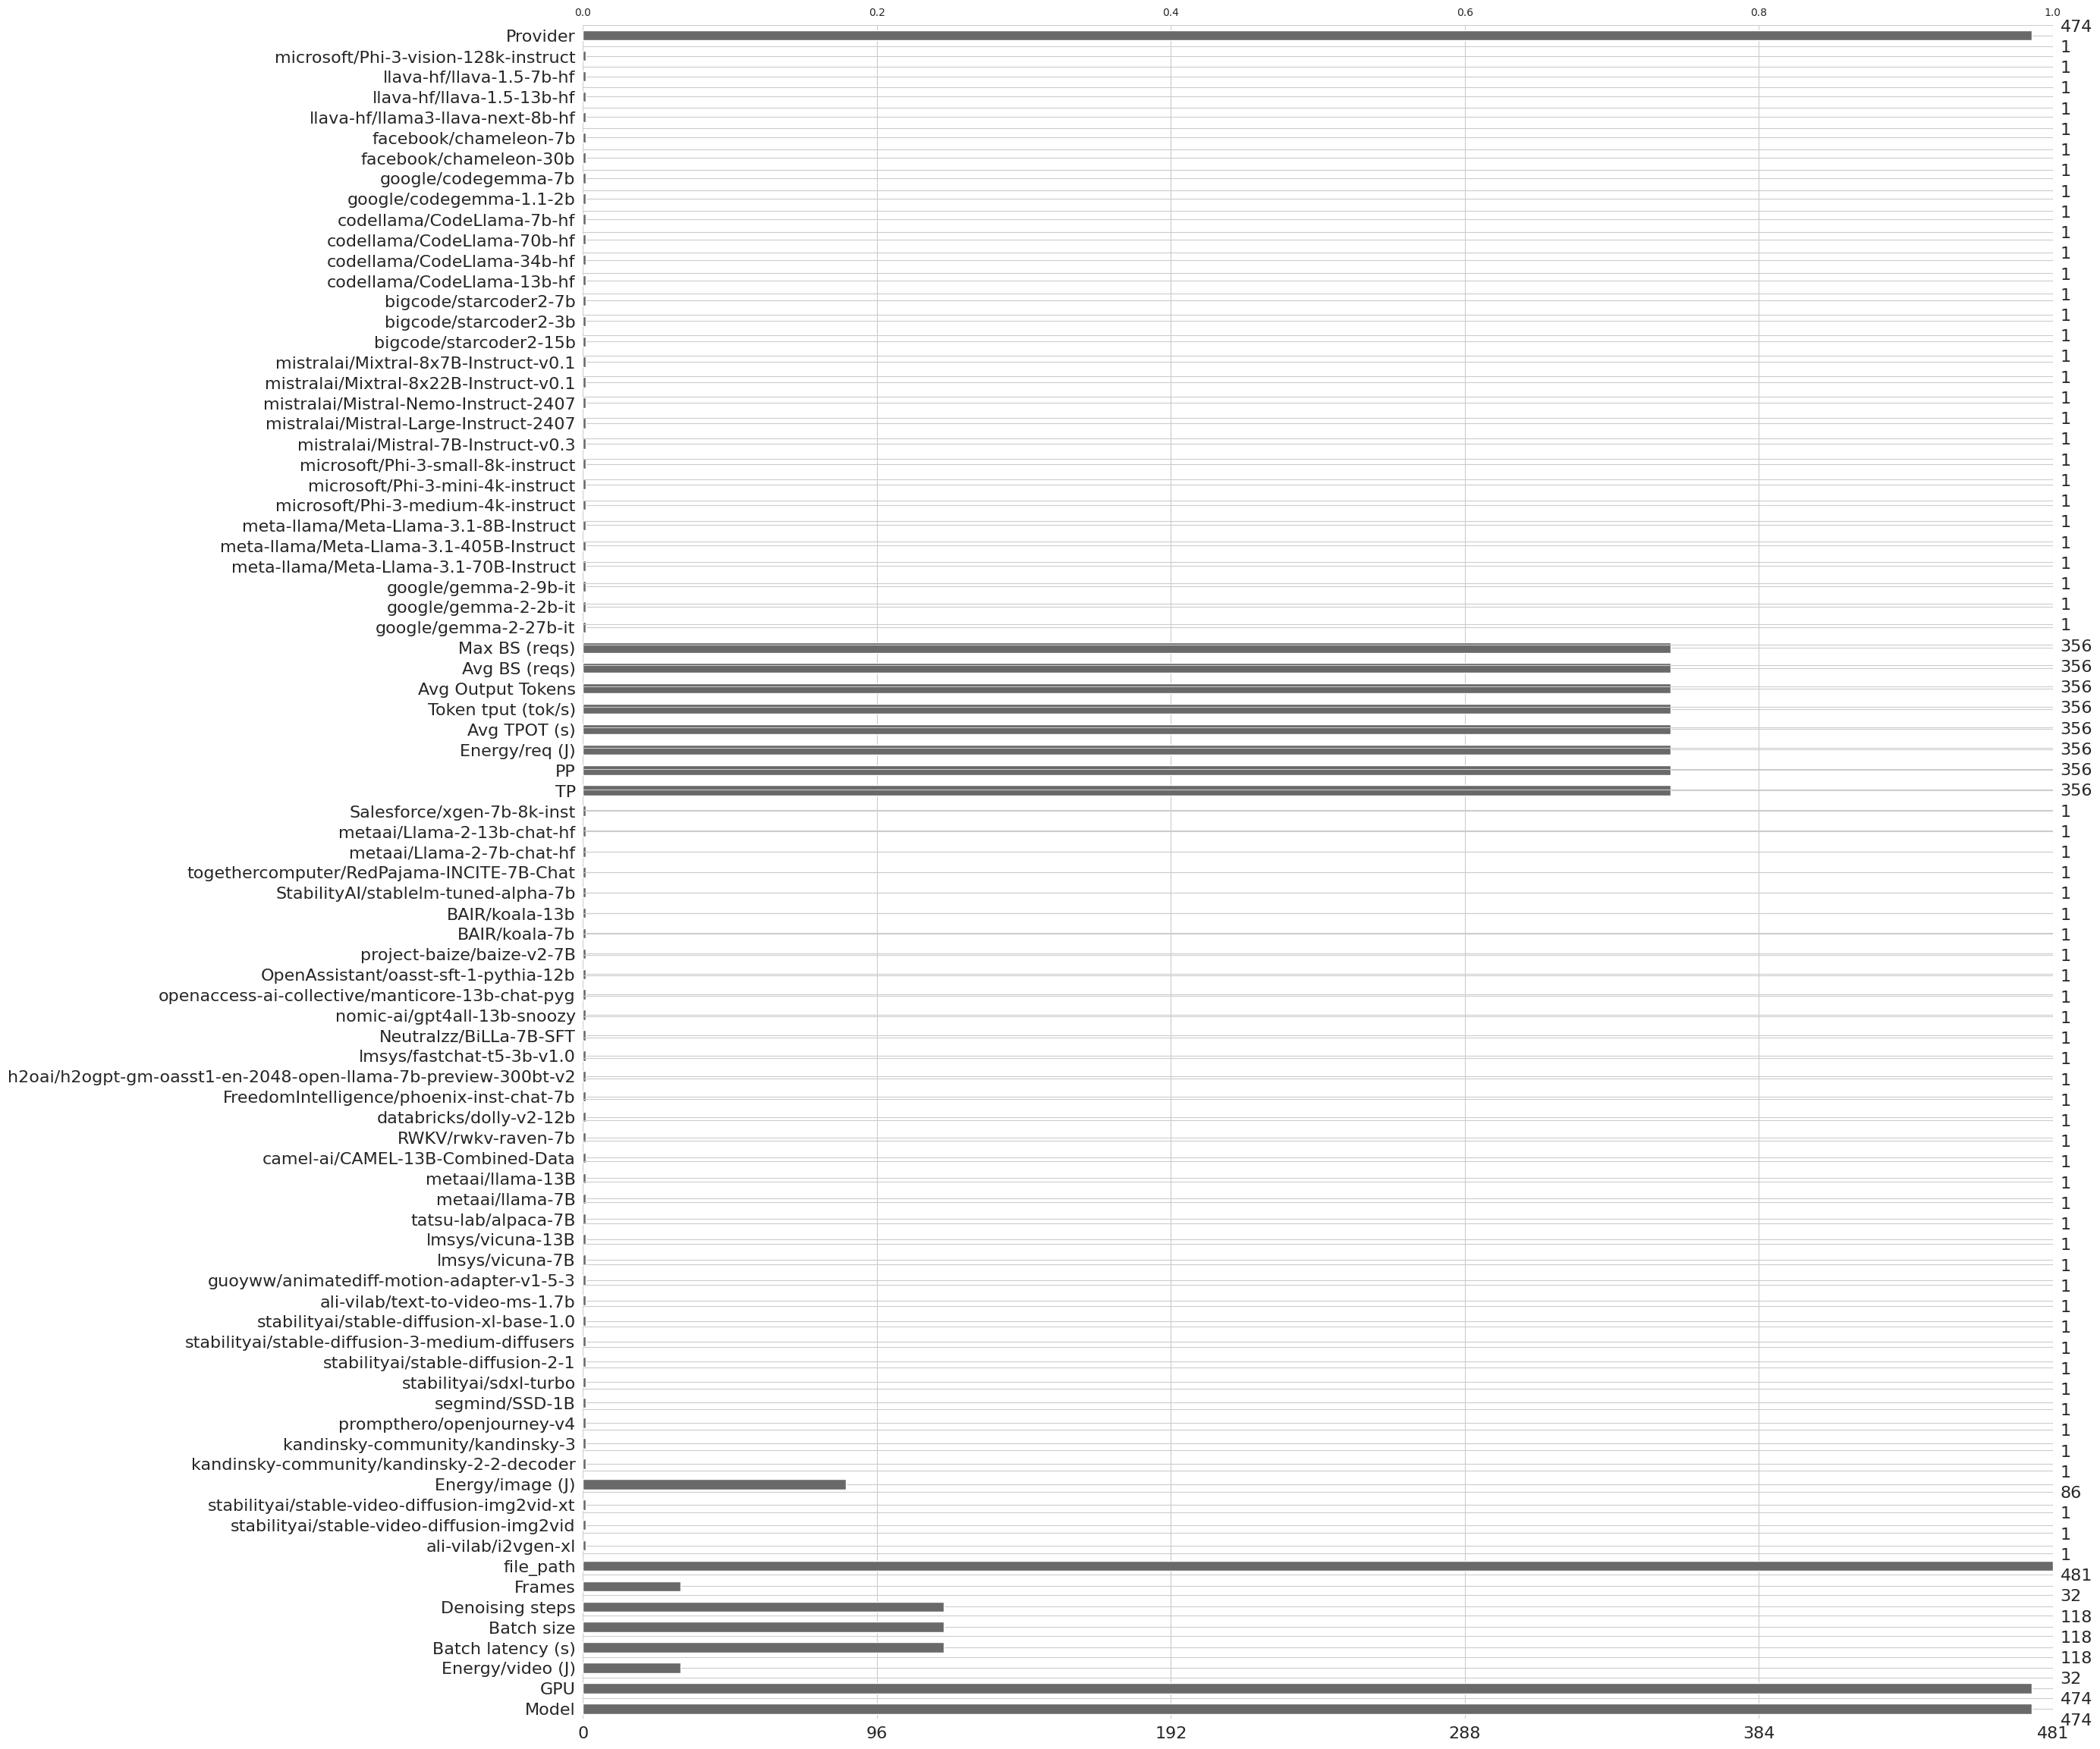

In [ ]:
## visualize the missingness
ms.bar(df)
plt.show()

<Axes: >

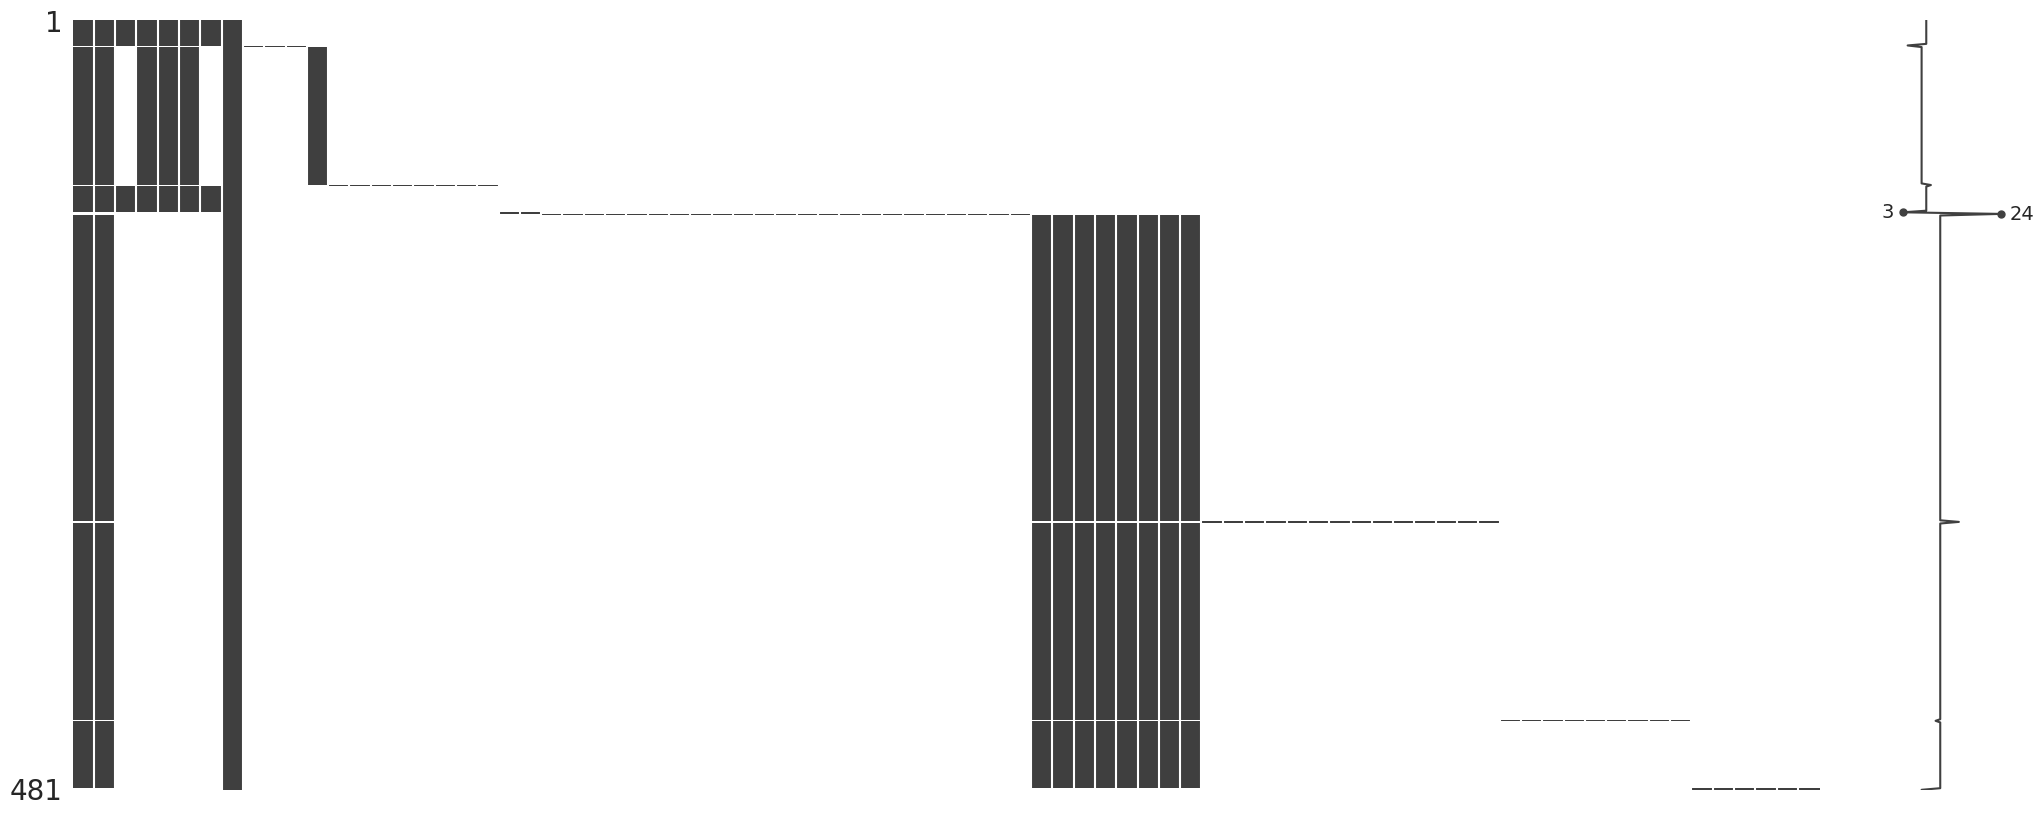

In [ ]:
ms.matrix(df)

<Axes: >

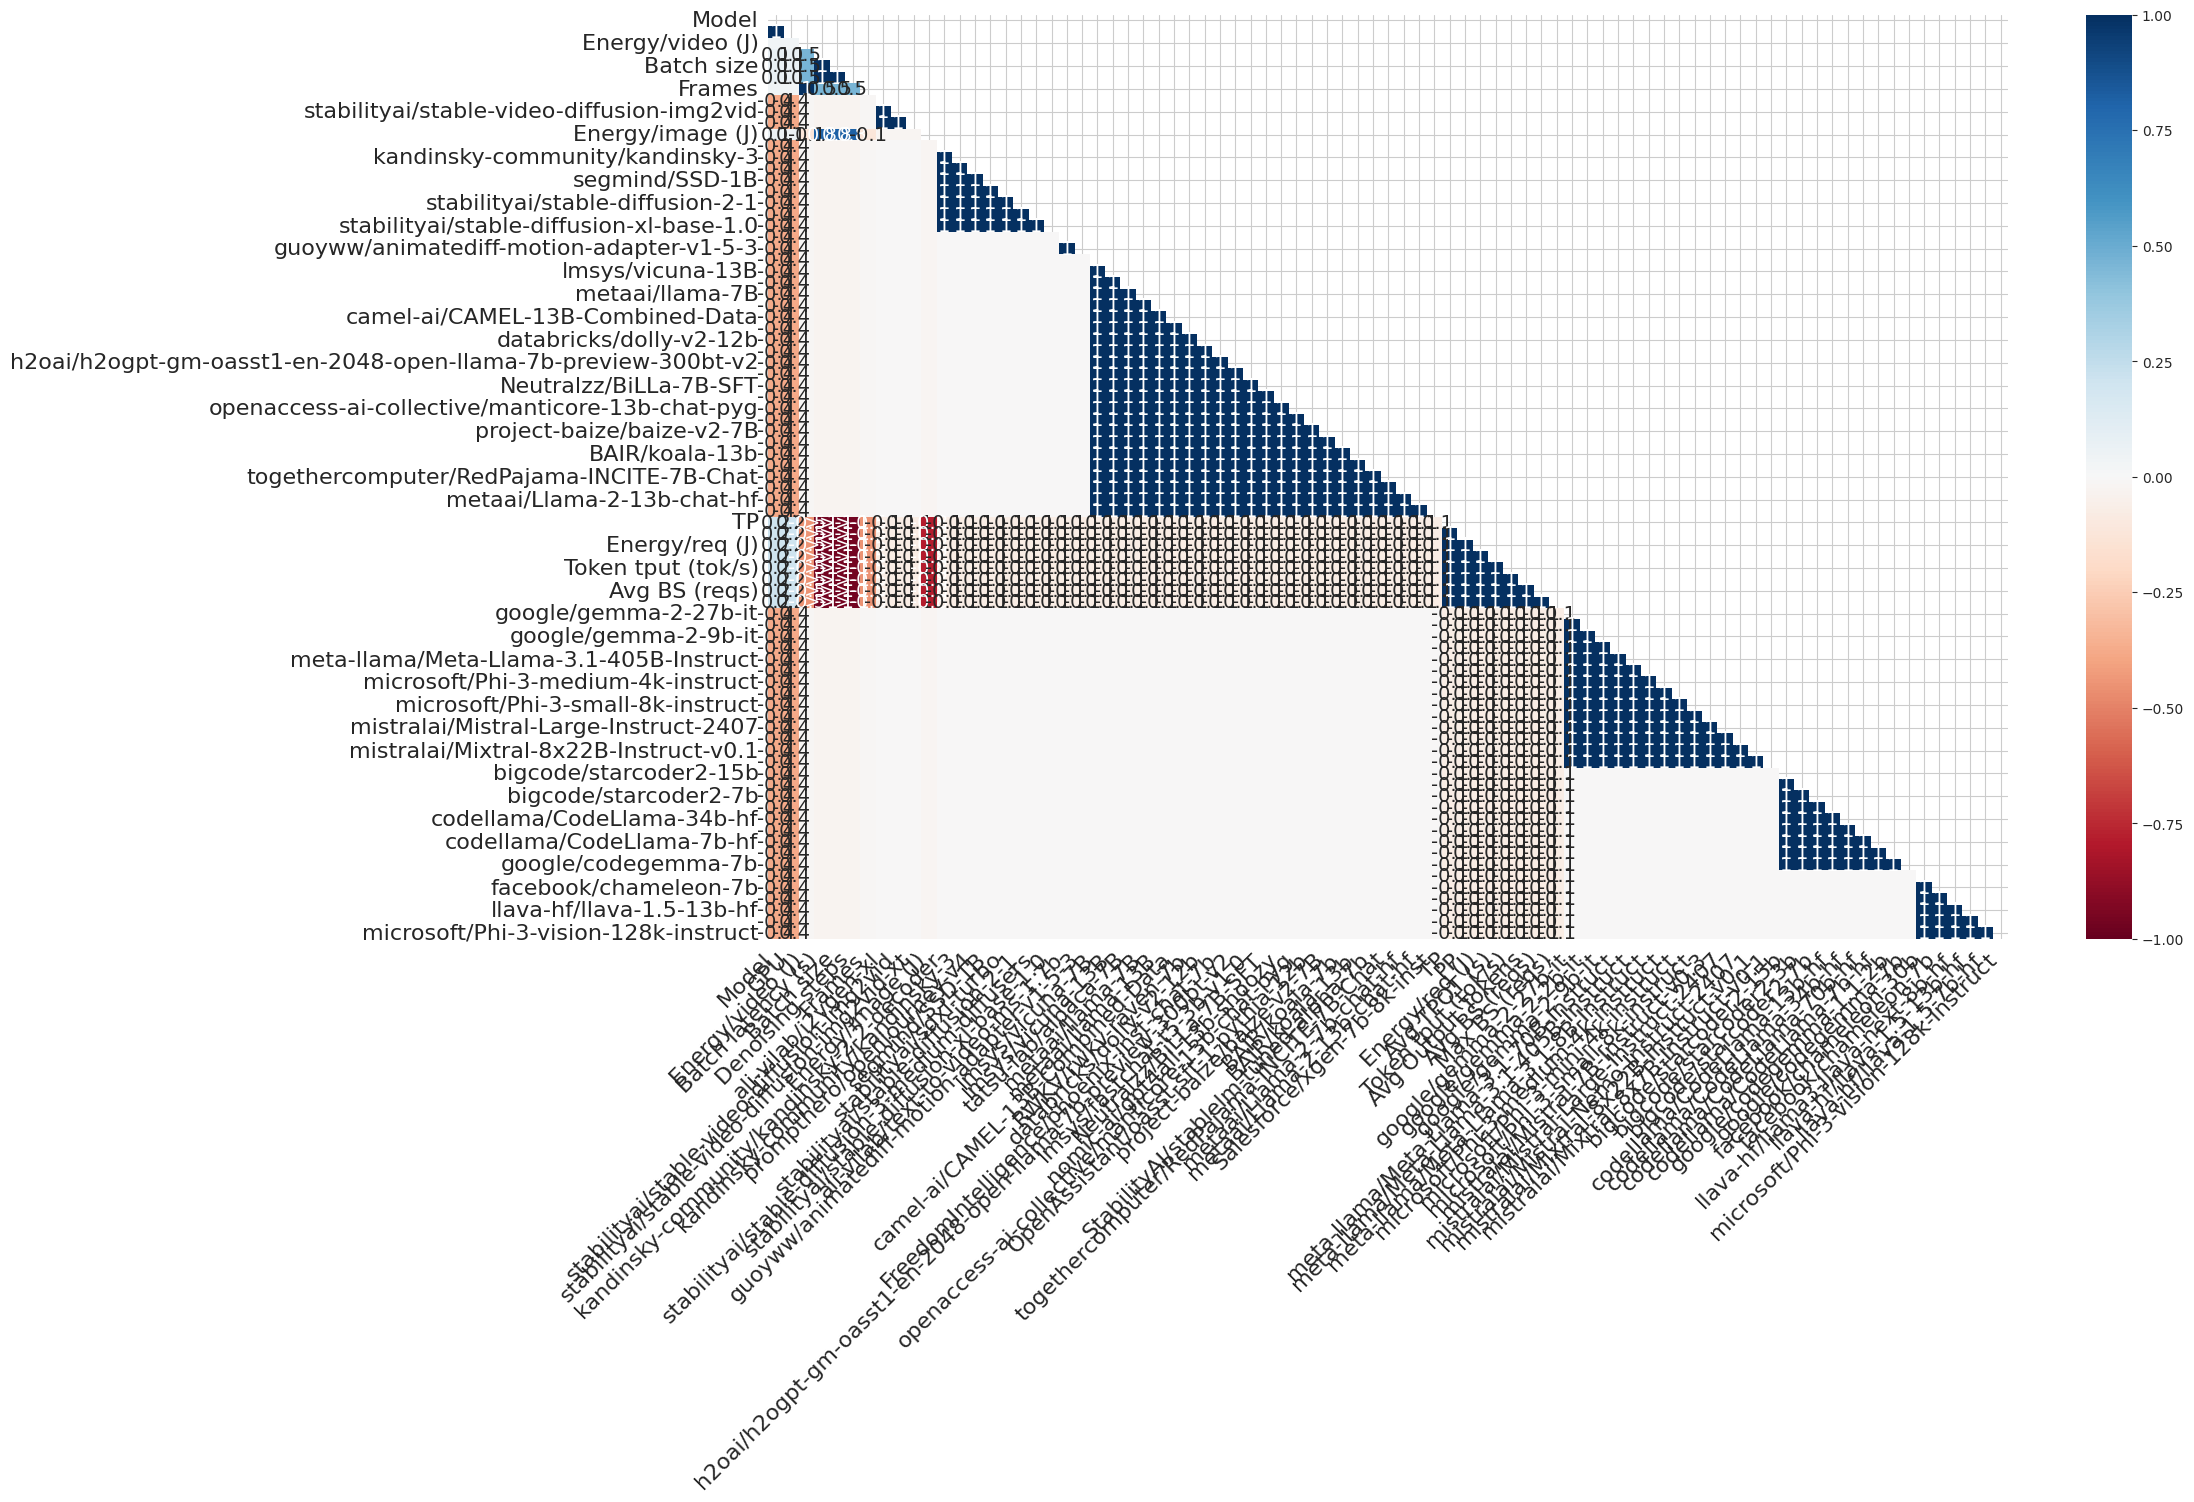

In [ ]:
ms.heatmap(df)

In [ ]:
df_num.isnull().sum()/len(df_num)

,0
Energy/video (J),0.933472
Batch latency (s),0.754678
Batch size,0.754678
Denoising steps,0.754678
Frames,0.933472
Energy/image (J),0.821206
TP,0.259875
PP,0.259875
Energy/req (J),0.259875
Avg TPOT (s),0.259875


## Cleaning: Removing Empty Columns

In [ ]:
# Calculate the percentage of missing values
missing_percent = (df.isnull().sum() / len(df)) * 100

# Columns that are completely empty (100% NaN)
empty_cols = missing_percent[missing_percent > 95].index.tolist()
df_red = df.drop(columns=empty_cols)
df_red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481 entries, 0 to 480
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Model               474 non-null    object 
 1   GPU                 474 non-null    object 
 2   Energy/video (J)    32 non-null     float64
 3   Batch latency (s)   118 non-null    float64
 4   Batch size          118 non-null    float64
 5   Denoising steps     118 non-null    float64
 6   Frames              32 non-null     float64
 7   file_path           481 non-null    object 
 8   Energy/image (J)    86 non-null     float64
 9   TP                  356 non-null    float64
 10  PP                  356 non-null    float64
 11  Energy/req (J)      356 non-null    float64
 12  Avg TPOT (s)        356 non-null    float64
 13  Token tput (tok/s)  356 non-null    float64
 14  Avg Output Tokens   356 non-null    float64
 15  Avg BS (reqs)       356 non-null    float64
 16  Max BS (

In [ ]:
## filter out only the numeric columns
df_red_num = df_red.select_dtypes(include=np.number)
df_red_num.describe().T

,count,mean,std,min,25%,50%,75%,max
Energy/video (J),32.0,7086.535588,5875.668906,812.813419,1076.134706,5581.194417,13024.577969,16915.850125
Batch latency (s),118.0,13.808459,19.501813,0.866557,2.378594,6.224474,15.374193,120.650049
Batch size,118.0,9.203390,14.191342,1.000000,2.000000,4.000000,8.000000,64.000000
Denoising steps,118.0,25.000000,0.000000,25.000000,25.000000,25.000000,25.000000,25.000000
Frames,32.0,17.312500,3.830586,14.000000,16.000000,16.000000,16.000000,25.000000
Energy/image (J),86.0,508.863035,380.904710,128.089934,185.872872,343.571114,743.752303,1457.979700
TP,356.0,2.747191,2.572469,1.000000,1.000000,1.000000,4.000000,8.000000
PP,356.0,1.047753,0.213543,1.000000,1.000000,1.000000,1.000000,2.000000
Energy/req (J),356.0,212.697273,381.218503,5.607688,36.412239,71.395469,188.270890,3352.922461
Avg TPOT (s),356.0,0.138113,0.106524,0.022732,0.069225,0.108140,0.173294,0.820531


## Check for duplicates

In [ ]:
# Check for duplicates,
df_red.duplicated().sum()

np.int64(0)

# **2. DATA CLEANING & IMPUTATION**

In [ ]:
## cleaning column names
df_red['Provider'] = df_red['Model'].str.split('/').str[0]
df_red['Model'] = df['Model'].str.split('/').str[1]
df_red.head()

,Model,GPU,Energy/video (J),Batch latency (s),Batch size,Frames,file_path,Energy/image (J),TP,PP,Energy/req (J),Avg TPOT (s),Token tput (tok/s),Avg Output Tokens,Avg BS (reqs),Max BS (reqs),path_task,Provider
0,i2vgen-xl,NVIDIA A100-SXM4-40GB,16915.850125,46.142083,1.0,16.0,data/diffusion/image-to-video/A100-SXM4-40GB/a...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,image-to-video,ali-vilab
1,i2vgen-xl,NVIDIA A100-SXM4-40GB,16496.045437,89.030190,2.0,16.0,data/diffusion/image-to-video/A100-SXM4-40GB/a...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,image-to-video,ali-vilab
2,stable-video-diffusion-img2vid-xt,NVIDIA A100-SXM4-40GB,15709.767625,42.397395,1.0,25.0,data/diffusion/image-to-video/A100-SXM4-40GB/s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,image-to-video,stabilityai
3,stable-video-diffusion-img2vid-xt,NVIDIA A100-SXM4-40GB,15291.016625,82.904748,2.0,25.0,data/diffusion/image-to-video/A100-SXM4-40GB/s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,image-to-video,stabilityai
4,stable-video-diffusion-img2vid-xt,NVIDIA A100-SXM4-40GB,14761.390000,120.650049,3.0,25.0,data/diffusion/image-to-video/A100-SXM4-40GB/s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,image-to-video,stabilityai


<Axes: >

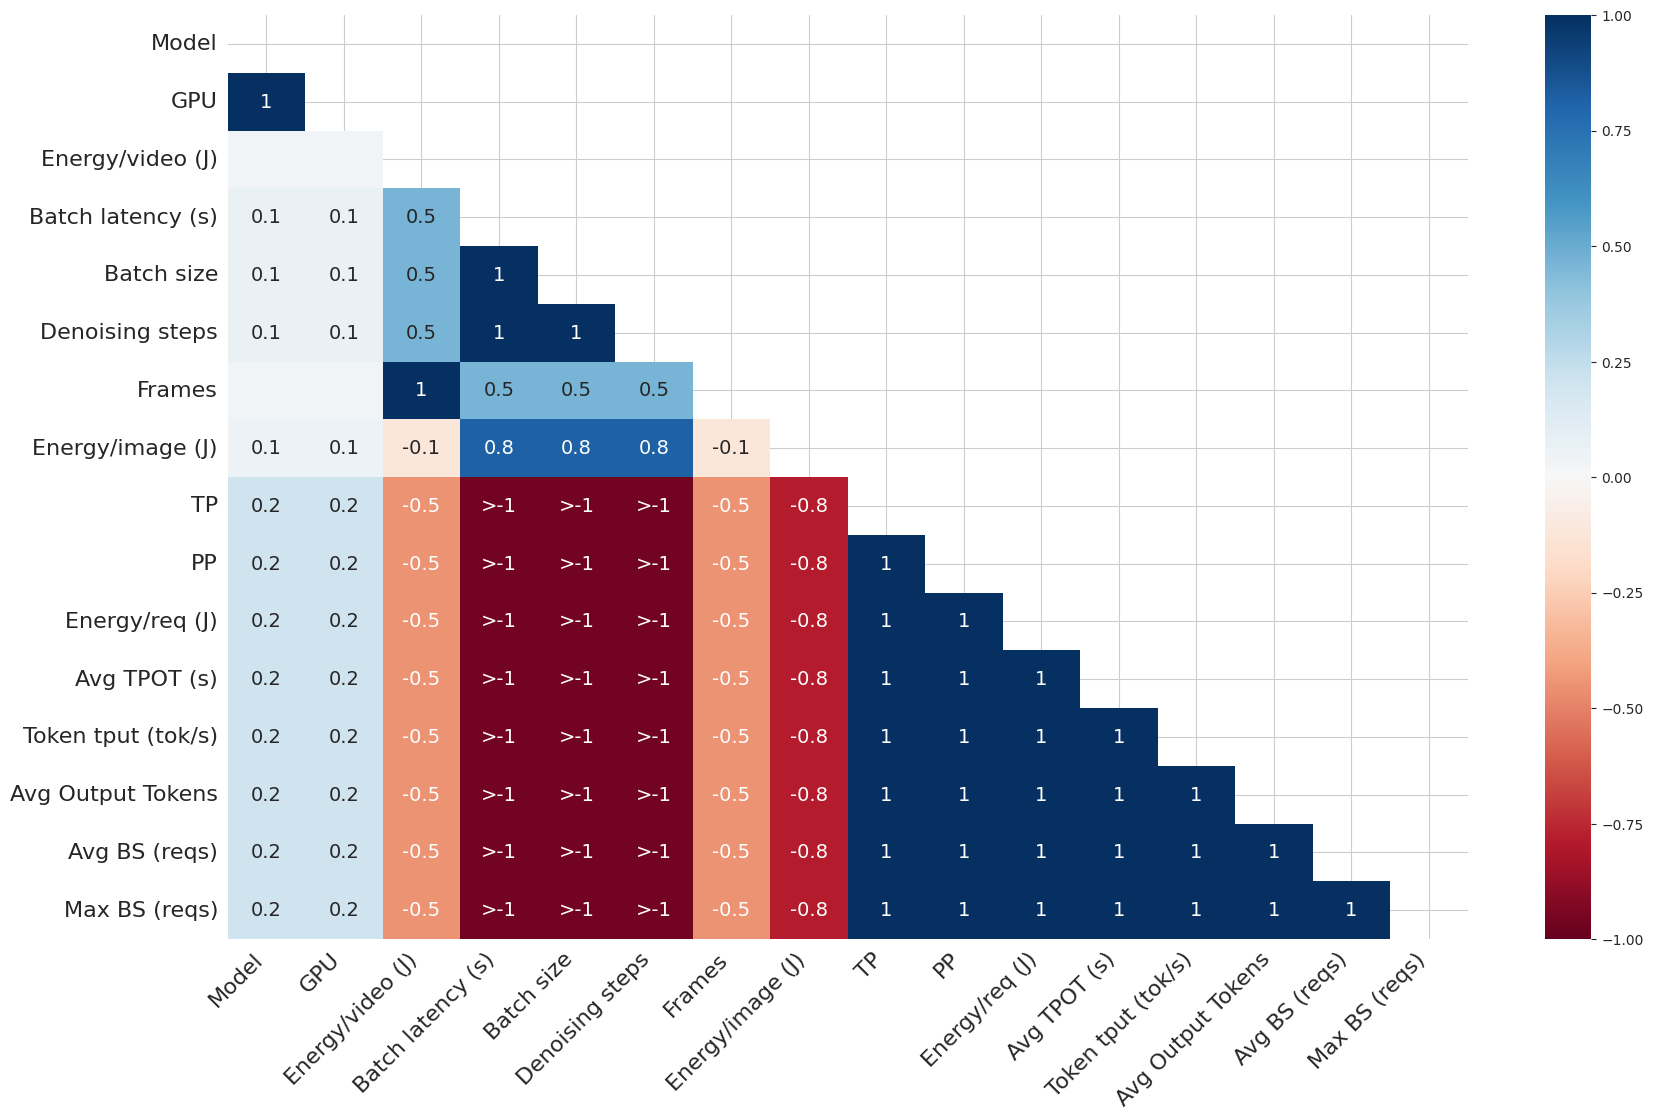

In [ ]:
ms.heatmap(df_red)

## Cleaning: Define and Convert Columns

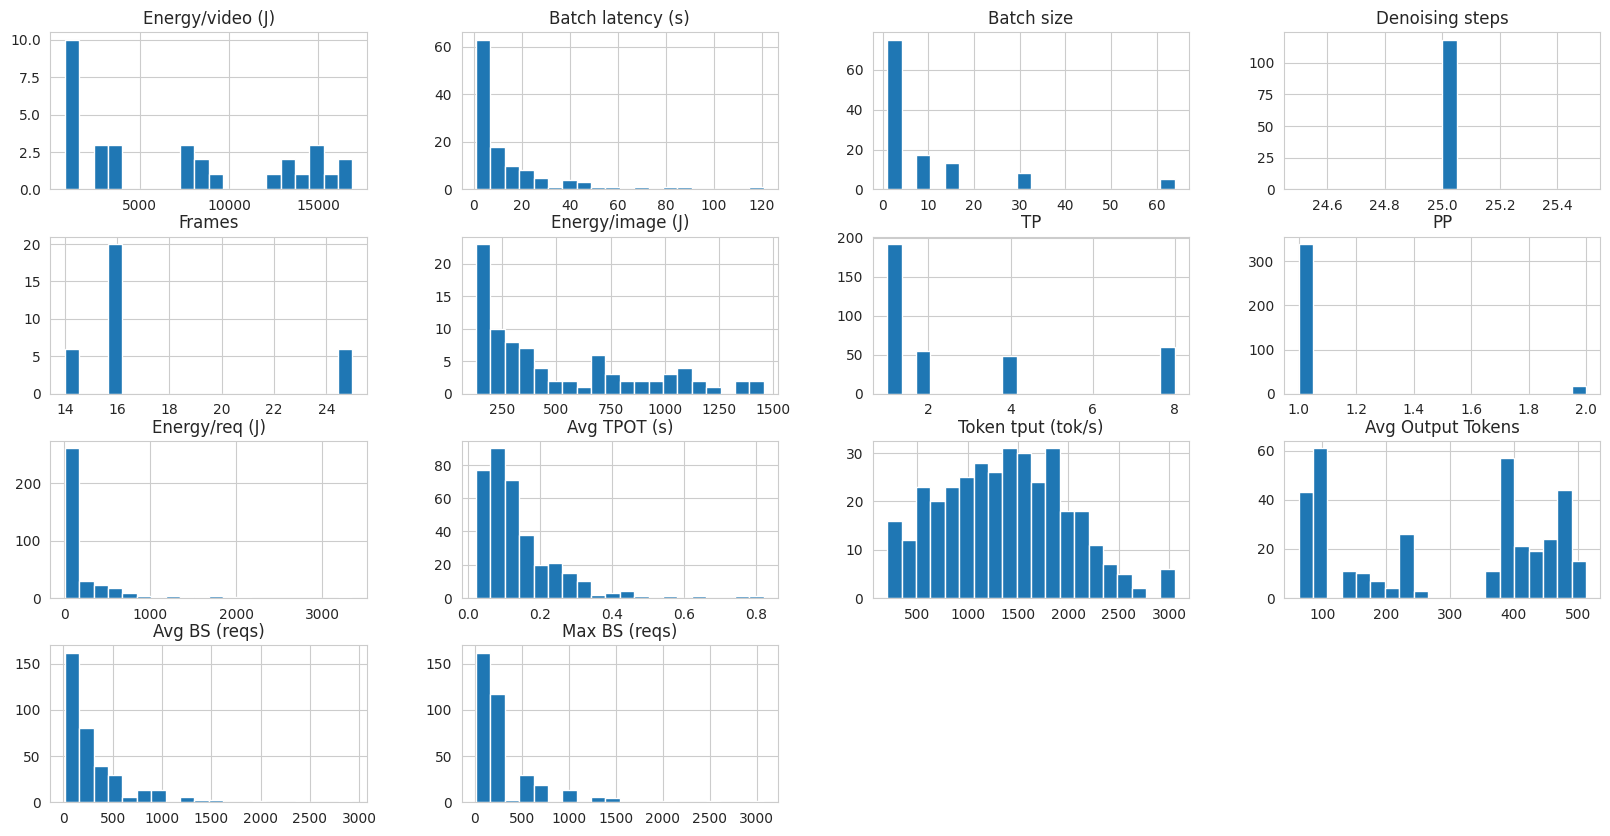

In [ ]:
df_red.hist(figsize=(20, 10), bins=20)
plt.show()

In [ ]:
df_red['Denoising steps'].value_counts(dropna=False)

,count
Denoising steps,
NaN,363
25.0,118


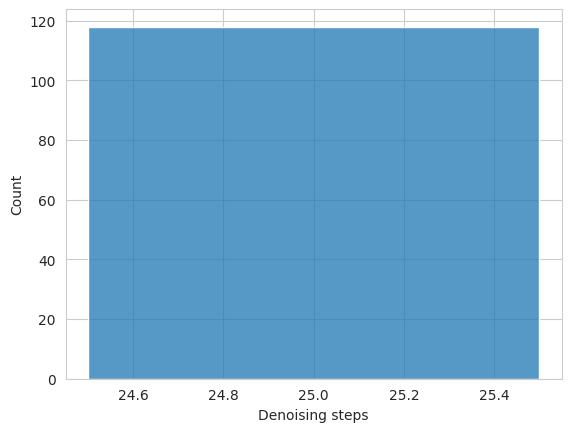

In [ ]:
sns.histplot(df_red['Denoising steps'])
plt.show()

In [ ]:
## drop 'denoising steps' column
df_red = df_red.drop(columns=['Denoising steps'], axis=1)

In [ ]:
df['Energy/req (J)'].describe()

,Energy/req (J)
count,356.000000
mean,212.697273
std,381.218503
min,5.607688
25%,36.412239
50%,71.395469
75%,188.270890
max,3352.922461


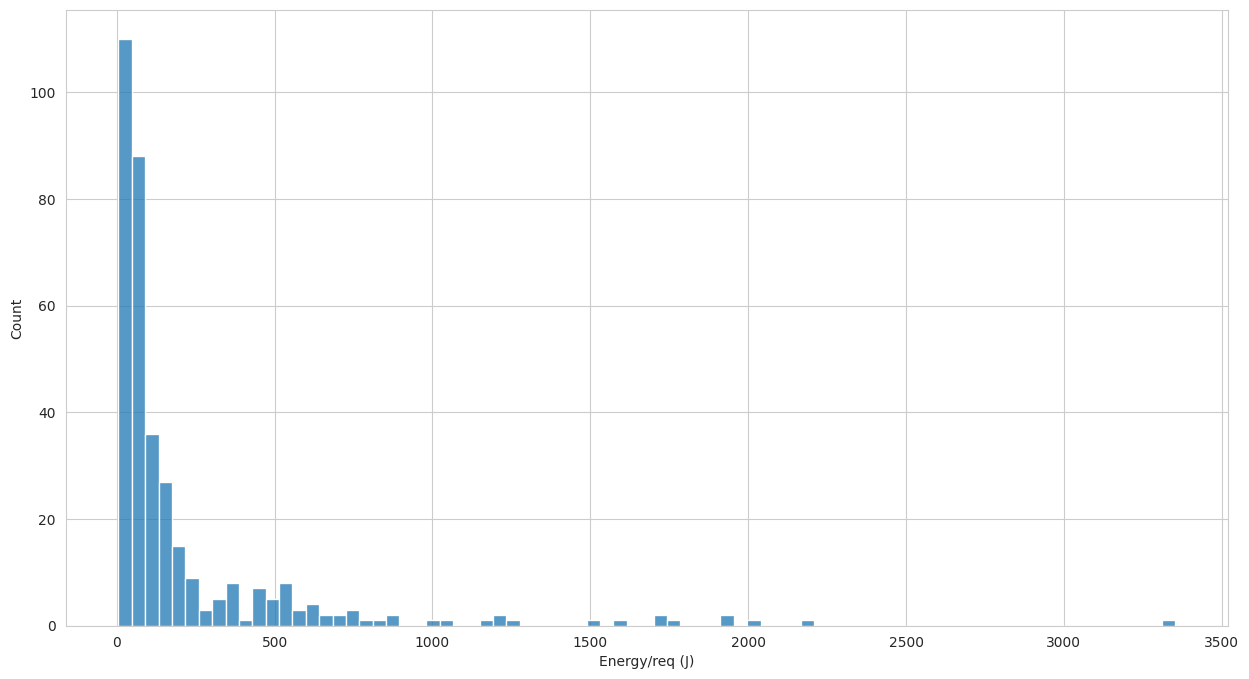

In [ ]:
plt.figure(figsize=(15, 8))
sns.histplot(df['Energy/req (J)'])
plt.show()

## Imputing Missing Values

In [ ]:
df_red_cat = df_red.select_dtypes(exclude=np.number)
df_red_cat.describe().T

,count,unique,top,freq
Model,474,42,mistralai/Mixtral-8x22B-Instruct-v0.1,23
GPU,474,2,NVIDIA A100-SXM4-40GB,244
file_path,481,481,data/mllm_text_generation/chat/models.json,1


In [ ]:
df_red_cat.isnull().sum()

,0
Model,7
GPU,7
file_path,0


In [ ]:
# Separate columns for imputation
categorical_cols = ['file_path', 'Model', 'GPU']
df_red_num = df_red.select_dtypes(include=np.number)
numeric_cols = df_red_num.columns.tolist()

In [ ]:
# 1. Impute categorical columns using the mode
for col in categorical_cols:
    if df_red[col].isnull().any():
        mode_value = df_red[col].mode()[0]
        df_red[col] = df_red[col].fillna(mode_value)

In [ ]:
# 2. Impute numeric columns using KNNImputer
if numeric_cols:
    imputer = KNNImputer(n_neighbors=5)
    df_imputed_array = imputer.fit_transform(df_red[numeric_cols])
    df_imputed_numeric = pd.DataFrame(df_imputed_array, columns=numeric_cols, index=df_red.index)

    df_final = pd.concat([df_red[categorical_cols], df_imputed_numeric], axis=1)
else:
    df_final = df_red.copy()
df_final.isnull().sum()

,0
file_path,0
Model,0
GPU,0
Energy/video (J),0
Batch latency (s),0
Batch size,0
Frames,0
Energy/image (J),0
TP,0
PP,0


# **3. PICKLING THE FILE**

In [ ]:
# Save the cleaned and imputed DataFrame to disk for quick reloading
pickle_file = 'df_ai_performance_clean.pkl'
with open(pickle_file, 'wb') as f:
    pickle.dump(df_final, f)
print(f"\nDataFrame pickled successfully to: {pickle_file}")

# Optional: Load the file to prove it works
# with open(pickle_file, 'rb') as f:
#     df_loaded = pickle.load(f)
# print(f"Loaded DataFrame shape: {df_loaded.shape}")


DataFrame pickled successfully to: df_ai_performance_clean.pkl


# **4. FEATURE ENGINEERING**

In [ ]:
df['file_path'].loc[0]

'data/diffusion/image-to-video/A100-SXM4-40GB/ali-vilab/i2vgen-xl/bs1+steps25+frames16.json'

In [ ]:
# Extract task information from file paths in JSON
df_final['path_task'] = df_final['file_path'].str.split('/').str[2]
df_final['path_task'].value_counts()

,count
path_task,
chat,235
code,124
text-to-image,87
image-to-video,17
text-to-video,17
models.json,1


In [ ]:
df_final = df_final.drop(columns=['file_path'], axis=1)
df_final.head()

,Model,GPU,Energy/video (J),Batch latency (s),Batch size,Frames,Energy/image (J),TP,PP,Energy/req (J),Avg TPOT (s),Token tput (tok/s),Avg Output Tokens,Avg BS (reqs),Max BS (reqs),path_task
0,ali-vilab/i2vgen-xl,NVIDIA A100-SXM4-40GB,16915.850125,46.142083,1.0,16.0,1199.337707,2.747191,1.047753,212.697273,0.138113,1368.901716,291.01962,298.728394,303.623596,image-to-video
1,ali-vilab/i2vgen-xl,NVIDIA A100-SXM4-40GB,16496.045437,89.030190,2.0,16.0,992.811757,2.747191,1.047753,212.697273,0.138113,1368.901716,291.01962,298.728394,303.623596,image-to-video
2,stabilityai/stable-video-diffusion-img2vid-xt,NVIDIA A100-SXM4-40GB,15709.767625,42.397395,1.0,25.0,1116.536751,2.747191,1.047753,212.697273,0.138113,1368.901716,291.01962,298.728394,303.623596,image-to-video
3,stabilityai/stable-video-diffusion-img2vid-xt,NVIDIA A100-SXM4-40GB,15291.016625,82.904748,2.0,25.0,992.811757,2.747191,1.047753,212.697273,0.138113,1368.901716,291.01962,298.728394,303.623596,image-to-video
4,stabilityai/stable-video-diffusion-img2vid-xt,NVIDIA A100-SXM4-40GB,14761.390000,120.650049,3.0,25.0,992.811757,2.747191,1.047753,212.697273,0.138113,1368.901716,291.01962,298.728394,303.623596,image-to-video


In [ ]:
### Simple Feature Engineering
# Create a complexity score (simple multiplication of two key input parameters)
df_final['Complexity_Score'] = df_final['Batch size'] * df_final['Avg BS (reqs)']
df_final.head()

,Model,GPU,Energy/video (J),Batch latency (s),Batch size,Frames,Energy/image (J),TP,PP,Energy/req (J),Avg TPOT (s),Token tput (tok/s),Avg Output Tokens,Avg BS (reqs),Max BS (reqs),path_task,Complexity_Score
0,ali-vilab/i2vgen-xl,NVIDIA A100-SXM4-40GB,16915.850125,46.142083,1.0,16.0,1199.337707,2.747191,1.047753,212.697273,0.138113,1368.901716,291.01962,298.728394,303.623596,image-to-video,298.728394
1,ali-vilab/i2vgen-xl,NVIDIA A100-SXM4-40GB,16496.045437,89.030190,2.0,16.0,992.811757,2.747191,1.047753,212.697273,0.138113,1368.901716,291.01962,298.728394,303.623596,image-to-video,597.456788
2,stabilityai/stable-video-diffusion-img2vid-xt,NVIDIA A100-SXM4-40GB,15709.767625,42.397395,1.0,25.0,1116.536751,2.747191,1.047753,212.697273,0.138113,1368.901716,291.01962,298.728394,303.623596,image-to-video,298.728394
3,stabilityai/stable-video-diffusion-img2vid-xt,NVIDIA A100-SXM4-40GB,15291.016625,82.904748,2.0,25.0,992.811757,2.747191,1.047753,212.697273,0.138113,1368.901716,291.01962,298.728394,303.623596,image-to-video,597.456788
4,stabilityai/stable-video-diffusion-img2vid-xt,NVIDIA A100-SXM4-40GB,14761.390000,120.650049,3.0,25.0,992.811757,2.747191,1.047753,212.697273,0.138113,1368.901716,291.01962,298.728394,303.623596,image-to-video,896.185182


# **5. DATA EXPLORATION (EDA)**

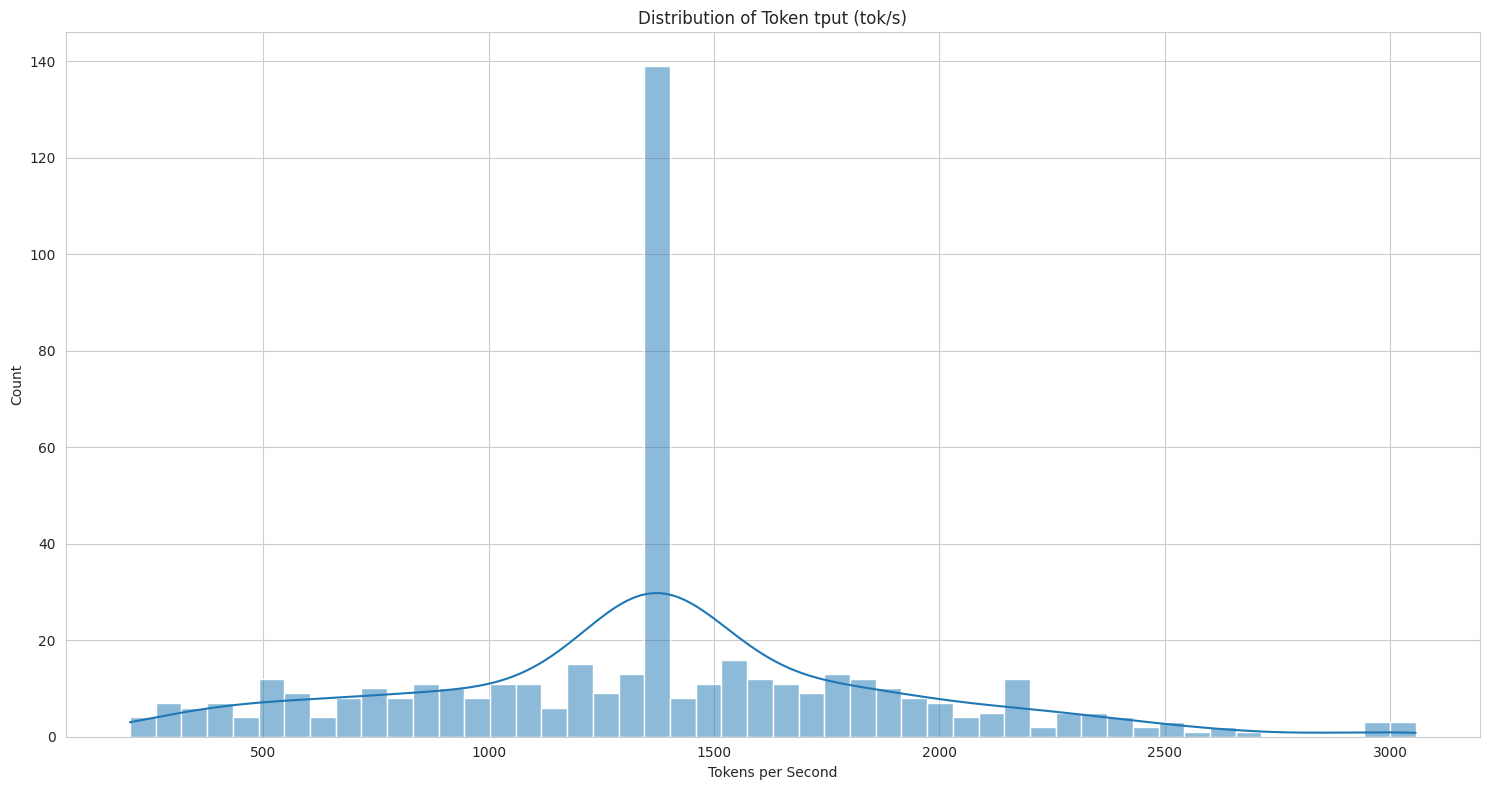

In [ ]:
# Identify final numeric columns for plotting
target_col = 'Token tput (tok/s)'

### Univariate Analysis (Distributions)
plt.figure(figsize=(15, 8))
sns.histplot(df_final[target_col], kde=True, bins=50)
plt.title(f'Distribution of {target_col}')
plt.xlabel("Tokens per Second")
plt.tight_layout()
plt.show()

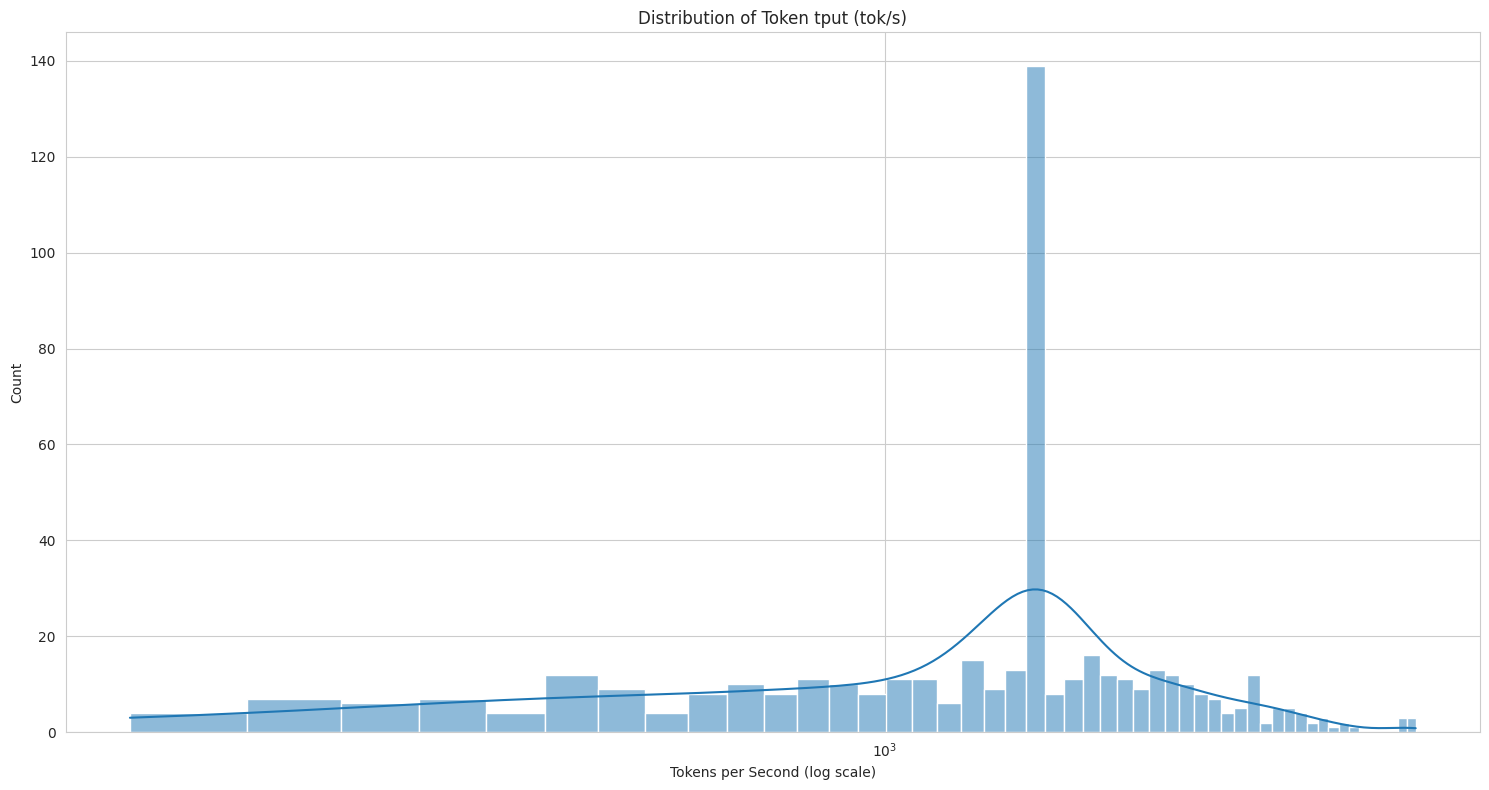

In [ ]:
# Identify final numeric columns for plotting
target_col = 'Token tput (tok/s)'

### Univariate Analysis (Distributions)
plt.figure(figsize=(15, 8))
sns.histplot(df_final[target_col], kde=True, bins=50)
plt.title(f'Distribution of {target_col}')
plt.xlabel("Tokens per Second (log scale)")
plt.xscale('log') # Throughput often benefits from a log scale
plt.tight_layout()
plt.show()

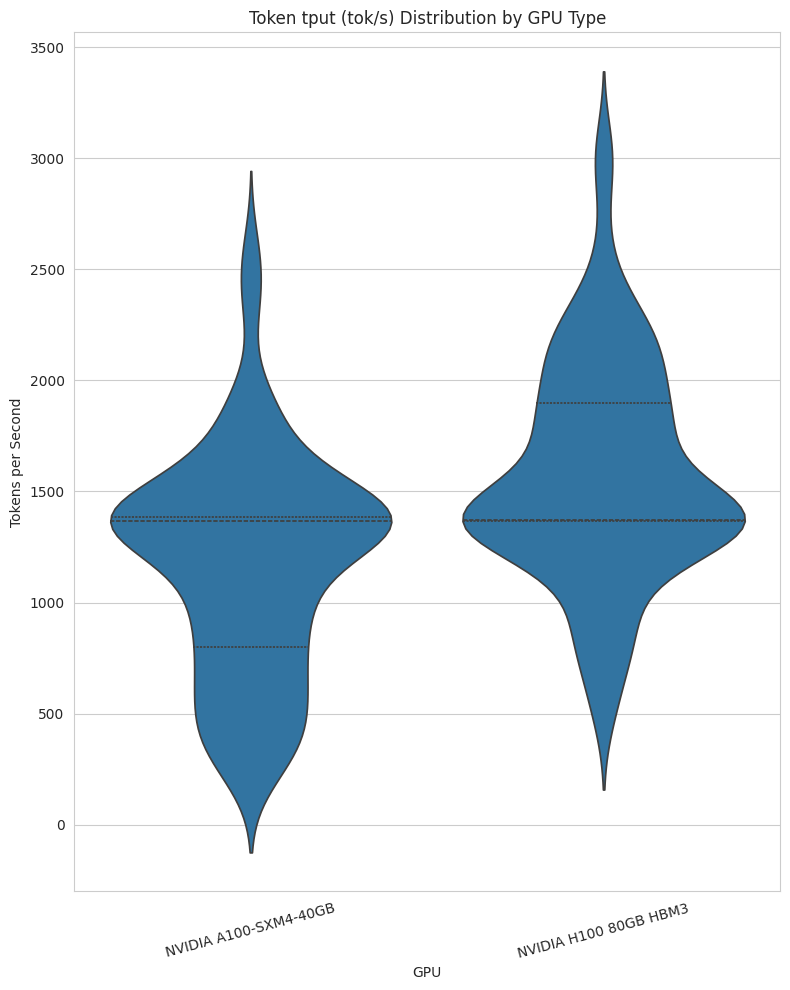

In [ ]:
### Bivariate Analysis (Performance vs. System)
plt.figure(figsize=(8, 10))
# Use violin plot to show the full distribution of throughput across different GPUs
sns.violinplot(x='GPU', y=target_col, data=df_final, inner='quartile')
plt.title(f'{target_col} Distribution by GPU Type')
plt.ylabel("Tokens per Second")
plt.xlabel("GPU")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

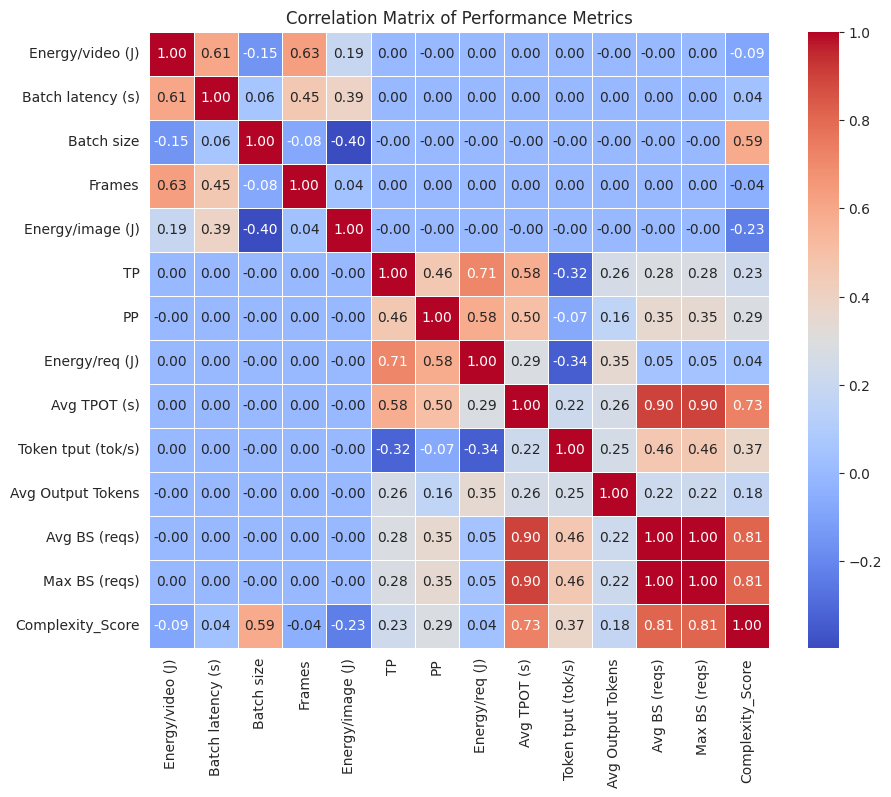

In [ ]:
## Multivariate Analysis (Correlation)
# Calculate the correlation matrix
correlation_matrix = df_final.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5
)
plt.title('Correlation Matrix of Performance Metrics')
plt.show()


## EDA: Distribution and Comparative Analysis ---

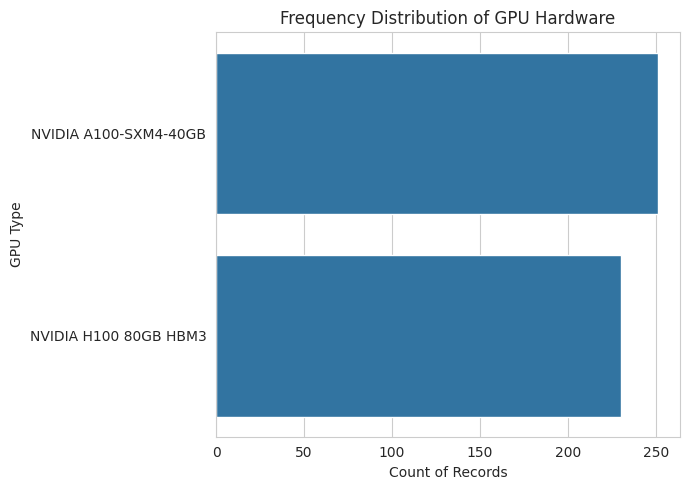

In [ ]:
## using token throughput as the targe
target_col = 'Token tput (tok/s)'

### Count Plot: Distribution of GPU Hardware
# This plot shows the number of times each GPU was tested, indicating dataset coverage.
plt.figure(figsize=(7, 5))
sns.countplot(y='GPU', data=df_final, order=df_final['GPU'].value_counts().index)
plt.title('Frequency Distribution of GPU Hardware')
plt.xlabel('Count of Records')
plt.ylabel('GPU Type')
plt.tight_layout()
plt.show()

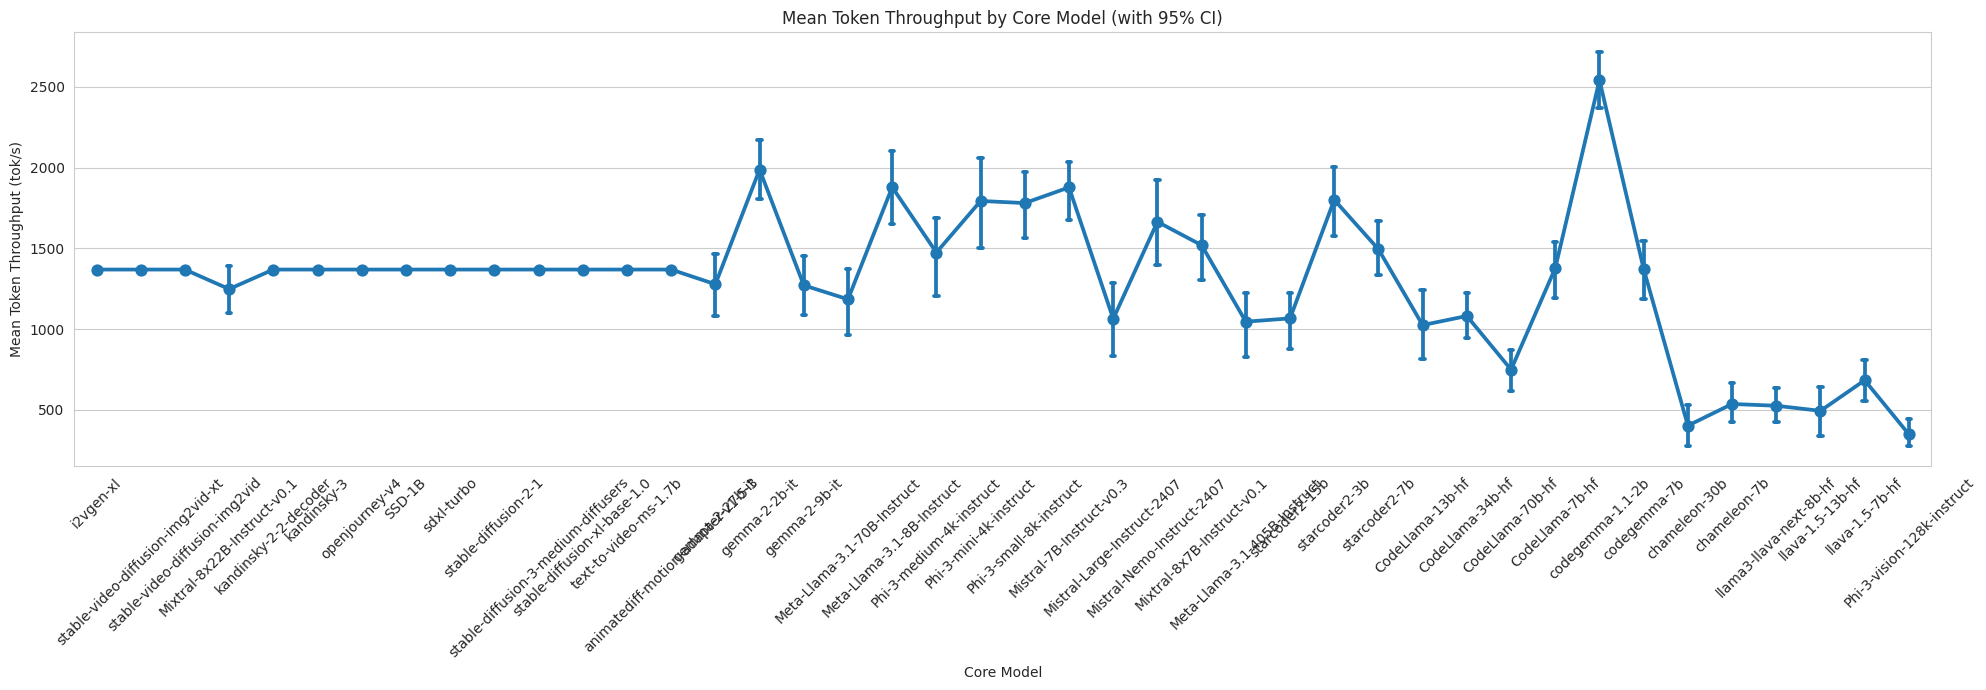

In [ ]:
### Point Plot 1: Throughput by Core Model
# Point plots display the mean and its confidence interval (CI), offering a statistically
plt.figure(figsize=(20, 7))
sns.pointplot(
    data=df_final,
    x='Model',
    y=target_col,
    errorbar=('ci', 95), # Show 95% Confidence Interval
    capsize=0.1
)
plt.title('Mean Token Throughput by Core Model (with 95% CI)')
plt.xlabel('Core Model')
plt.ylabel('Mean Token Throughput (tok/s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

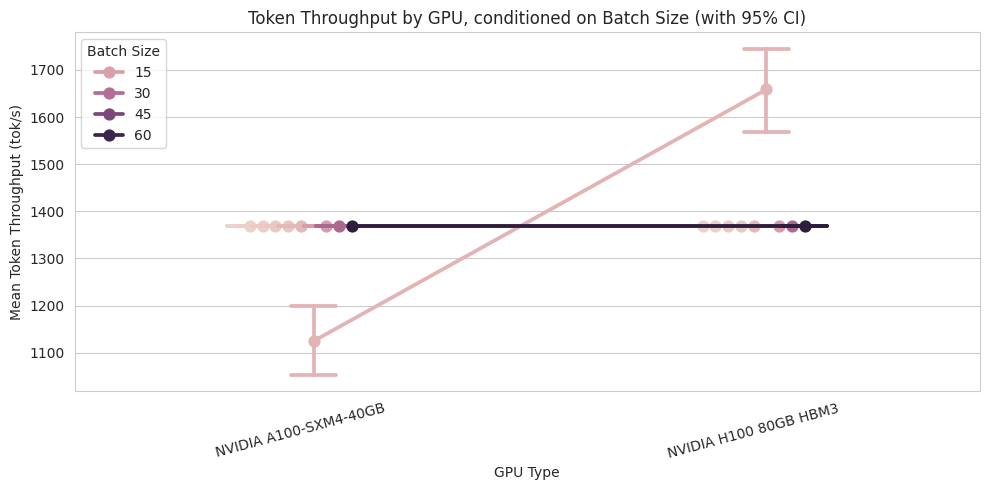

In [ ]:
### Point Plot 2: Throughput by GPU and Batch Size
# hardware (GPU) as the workload (Batch Size) increases.
plt.figure(figsize=(10, 5))
sns.pointplot(
    data=df_final,
    x='GPU',
    y=target_col,
    hue='Batch size',
    errorbar=('ci', 95),
    dodge=True,
    capsize=0.1
)
plt.title('Token Throughput by GPU, conditioned on Batch Size (with 95% CI)')
plt.xlabel('GPU Type')
plt.ylabel('Mean Token Throughput (tok/s)')
plt.xticks(rotation=15)
plt.legend(title='Batch Size', loc='upper left')
plt.tight_layout()
plt.show()

## Statistical Test: One-Way ANOVA

In [ ]:
# One-Way Analysis of Variance (ANOVA) tests if the means of three or more independent groups
# (our different GPU types) are statistically different from each other.

# 1. Gather the Token Throughput values for each unique GPU group
gpu_groups = [df_final[df_final['GPU'] == g][target_col].dropna() for g in df_final['GPU'].unique()]

# 2. Filter out groups that might be too small or have no variance (good practice)
gpu_groups = [g for g in gpu_groups if len(g) > 1 and g.var() > 0]

# 3. Perform the ANOVA test
if len(gpu_groups) >= 2:
    f_statistic, p_value = stats.f_oneway(*gpu_groups)
else:
    f_statistic, p_value = np.nan, np.nan

print("\n### Statistical Test: One-Way ANOVA (Token Throughput by GPU)")
print(f"F-Statistic: {f_statistic:.4f}")
print(f"P-Value: {p_value:.4f}")


### Statistical Test: One-Way ANOVA (Token Throughput by GPU)
F-Statistic: 77.9309
P-Value: 0.0000


## --- Findings from Statistical Test ---

In [ ]:
# Explanation for sns.pointplot() 1:
print("Point Plot (Model vs. Throughput): By comparing the mean Token Throughput across Core Models,")
print("we can quickly identify which models are inherently more efficient. Overlapping confidence")
print("intervals (the vertical bars) suggest that any observed difference in the mean is likely due")
print("to chance, while non-overlapping intervals indicate a statistically reliable difference.")

Point Plot (Model vs. Throughput): By comparing the mean Token Throughput across Core Models,
we can quickly identify which models are inherently more efficient. Overlapping confidence
intervals (the vertical bars) suggest that any observed difference in the mean is likely due
to chance, while non-overlapping intervals indicate a statistically reliable difference.


In [ ]:
# Explanation for sns.pointplot() 2:
print("Point Plot (GPU & Batch Size): This plot visualizes the **interaction effect**. If the lines")
print("for different batch sizes are parallel across GPUs, there is no interaction. If the lines")
print("cross or spread significantly, it shows that the optimal batch size is dependent on the GPU.")
print("For instance, a high-end GPU might scale linearly with Batch Size, while a low-end GPU might")
print("hit a performance wall quickly (plateauing lines).")

Point Plot (GPU & Batch Size): This plot visualizes the **interaction effect**. If the lines
for different batch sizes are parallel across GPUs, there is no interaction. If the lines
cross or spread significantly, it shows that the optimal batch size is dependent on the GPU.
For instance, a high-end GPU might scale linearly with Batch Size, while a low-end GPU might
hit a performance wall quickly (plateauing lines).


In [ ]:
# Explanation for ANOVA Test:
if not np.isnan(p_value) and p_value < 0.05:
    print(f"\nANOVA Finding: The P-Value ({p_value:.4f}) is less than the common significance level (0.05).")
    print("Conclusion: We reject the null hypothesis. There is a **statistically significant**")
    print("difference in the mean Token Throughput across the different GPU types. This confirms")
    print("that hardware choice is not only practically important but mathematically relevant.")
elif not np.isnan(p_value):
    print(f"\nANOVA Finding: The P-Value ({p_value:.4f}) is greater than 0.05.")
    print("Conclusion: We fail to reject the null hypothesis. The mean Token Throughput is NOT")
    print("statistically different across the GPU types (Note: This is unlikely given the data).")
else:
    print("\nANOVA Finding: Statistical test could not be performed (too few groups or data points).")


ANOVA Finding: The P-Value (0.0000) is less than the common significance level (0.05).
Conclusion: We reject the null hypothesis. There is a **statistically significant**
difference in the mean Token Throughput across the different GPU types. This confirms
that hardware choice is not only practically important but mathematically relevant.


# **6. EXPLANATION OF STEPS & MAJOR FINDINGS**